<h1>Training and Inference using UNET</h1>

Prerequisites:
- Google Drive account with the preprocessed images and masks folders
- GPU ("Runtime"-->"Change Runtime Type")

**Input:** Preprocessed GeoTiff images, 15 bands, 300x300 pixels and matching masks

**Output:** A trained UNET model, and predicted test masks

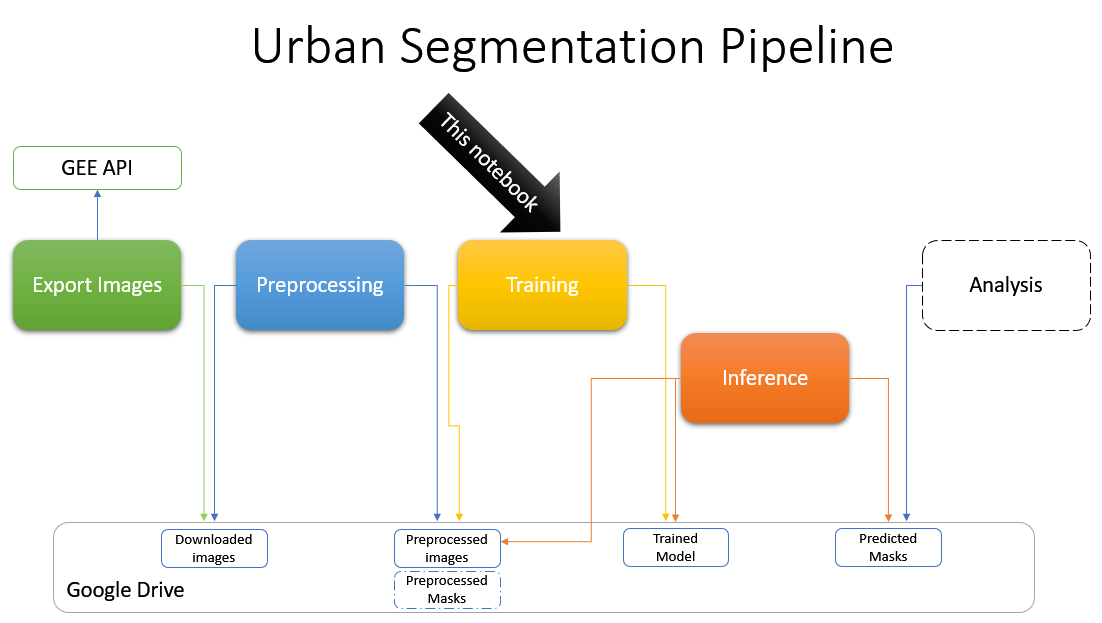

## Running instructions



1.   Connect to the NB
2.   Upload the ssh keys file on "Files" left side panel
3.   Update the preprocessed images and masks **parent path** in "REMOTE_EXPORT_DIR" in the next cell (images and masks will be copied locally to the NB directory "LOCAL_EXPORT_DIR")
4.   Run the notebook to train the model and perdict test masks
5. If you want to fine tune a trained model see the ["TRAINING - Hyperparams"](https://colab.research.google.com/drive/1Nt8iQDTHr39qFqpO36aN38tasQSSLzyZ?authuser=1#scrollTo=TRAINING_Hyperparams) section in this NB

In [1]:
#TODO >>>>>>>>>> CHANGE TO THE PREPROCESSED IMAGES AND MASKS PARENT DIRECTORY
REMOTE_EXPORT_DIR='/content/drive/MyDrive/2022/S1/3624_Final_Project/dataset/'
LOCAL_EXPORT_DIR='/content/'
#TODO >>>>>>>>>> CHANGE if you want your trained model to be saved elsewhere
TRAINED_MODEL_REMOTE_PATH = REMOTE_EXPORT_DIR + '../models/'
#TODO >>>>>>>>>> CHANGE to a directory with additional test images (without masks) and metadata - for final section inference
ADDITIONAL_TEST_DIR='/content/drive/MyDrive/gee_export_Jul_14_2022_1601test_prepproc/'
STATS_METADATA_DIR='/content/drive/MyDrive/gee_export_Jul_14_2022_1601test_metadata/'

#TODO >>>>>>>>>> CHANGE to False if you want to infer using the last trained model instead of training
FORCE_TRAIN=False

#TODO >>>>>>>>>> CHANGE to True in order to backup predictions to a drive path
BACKUP=False
REMOTE_TARGET_PREDS_DIR=REMOTE_EXPORT_DIR + '/../'

## Setup


Upload the Git credentials files on the left files panel (if using a secured)Git repo

Alternatively you can download the [Urban Segmentation Git](https://github.com/lleviraz/urban_segmentation) Repo as ZIP file, then upload and extract here 

In [2]:
import os
if(not os.path.exists('urban_segmentation')):
  if(os.path.exists('/root/.ssh')):
    !mv -f /root/.ssh /root/.ssh_old
  !unzip gitssh.zip && mv .ssh /root/ && chmod -R 400 /root/.ssh && ls /root/.ssh
  !git clone git@github.com:lleviraz/urban_segmentation.git

In [3]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install -q rasterio imagecodecs fastai albumentations torchmetrics

In [5]:
# Python General
import os
import gc
import sys
import glob
import random
import shutil
import numpy as np
import pandas as pd
import pprint as pp
from PIL import Image
from pathlib import Path
from copy import deepcopy
from datetime import datetime
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix

#for augmentations
import albumentations as A
from fastai.vision.all import *

#Torch
import torch
import torchmetrics
from torch import nn
from torchmetrics import Dice
from torchvision import transforms

#rasterio
import rasterio as rio
from rasterio.transform import Affine
from rasterio.plot import show_hist,show
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [6]:
SEED=777
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Env directories

In [7]:
#Current working directory
#TODO >>>>>>>>>> IF NEEDED CHANGE TO THE CURRENT WORKING DIRECTORY OF THE NOTEBOOK
WORK_DIR = 'urban_segmentation/'
NB_DIR = WORK_DIR + 'notebooks/'

# This directory is the parent of the "libs" directory which is imported below
sys.path.append(NB_DIR)

#FULL DATASET
# EXPORT_DIR = LOCAL_EXPORT_DIR
esm_aligned = os.path.join(LOCAL_EXPORT_DIR ,'esm_aligned/')
s2_resized = os.path.join(LOCAL_EXPORT_DIR,'s2_resized/')

# s2_resized_dev = os.path.join(LOCAL_EXPORT_DIR,'s2_resized_dev')
# esm_aligned_dev = os.path.join(LOCAL_EXPORT_DIR,'esm_aligned_dev')

s2_resized_test = os.path.join(LOCAL_EXPORT_DIR ,'s2_resized_test/')
esm_aligned_test = os.path.join(LOCAL_EXPORT_DIR ,'esm_aligned_test/')

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu' #GOOD FOR DEBUGGING
print('Using device:', device)

Using device: cuda


## Copy the dataset files from the Google Drive to a local storage 

In [9]:
%%time

# !rm -rf /content/esm_aligned
# !rm -rf /content/s2_resized

!cp -r -n {REMOTE_EXPORT_DIR}/s2_resized /content/
!cp -r -n {REMOTE_EXPORT_DIR}/esm_aligned /content/

#copy test dir anyway
# !rm -rf /content/esm_aligned_test
# !rm -rf /content/s2_resized_test
!cp -r -n {REMOTE_EXPORT_DIR}/s2_resized_test /content/
!cp -r -n {REMOTE_EXPORT_DIR}/esm_aligned_test /content/

CPU times: user 22.1 ms, sys: 56.4 ms, total: 78.5 ms
Wall time: 1.05 s


In [10]:
# !mv {REMOTE_EXPORT_DIR}/s2_resized {REMOTE_EXPORT_DIR}/s2_resized_orig
# !mv {REMOTE_EXPORT_DIR}/esm_aligned {REMOTE_EXPORT_DIR}/esm_aligned_orig
# !cp -r /content/s2_resized/ {REMOTE_EXPORT_DIR}
# !cp -r /content/esm_aligned/ {REMOTE_EXPORT_DIR}
# !cp -r /content/s2_resized_test/ {REMOTE_EXPORT_DIR}
# !cp -r /content/esm_aligned_test/ {REMOTE_EXPORT_DIR}

In [11]:
!ls {REMOTE_EXPORT_DIR}/s2_resized | wc -l
!ls {REMOTE_EXPORT_DIR}/esm_aligned | wc -l
!ls {REMOTE_EXPORT_DIR}/s2_resized_test | wc -l
!ls {REMOTE_EXPORT_DIR}/esm_aligned_test | wc -l

700
700
0
0


In [12]:
#Our implementation (can be called after setting env directories)
from libs.common import *
from libs.training import *
from libs.evaluation import *
from libs.inference import *

# from libs.metrics import *
# from libs.multichannel import *
# from libs.metrics import _fast_hist

## Train  Test Split

Use these utilities to move files and recreate the test or dev sets

In [13]:
# uncomment to reset test set folders
# !mv {REMOTE_EXPORT_DIR}/s2_resized_test/*.tif {REMOTE_EXPORT_DIR}/s2_resized
# !mv {REMOTE_EXPORT_DIR}/esm_aligned_test/*.tif {REMOTE_EXPORT_DIR}/esm_aligned
# !mv /content/esm_aligned_test/*.tif /content/esm_aligned
# !mv /content/s2_resized_test/*.tif /content/s2_resized
# !rm -rf {esm_aligned_test}
# !rm -rf {s2_resized_test}

# DEV
# !mv /content/s2_resized_dev/*.tif /content/s2_resized
# !mv /content/esm_aligned_dev/*.tif /content/esm_aligned
# !rm -rf {esm_aligned_dev}
# !rm -rf {s2_resized_dev}

In [14]:
NUM_DEV=0#50
NUM_TST=60

# With dev set
# create_dev_set(src_imgs_dir=s2_resized,src_masks_dir=esm_aligned,
#                tgt_imgs_dir=s2_resized_dev,
#                tgt_masks_dir=esm_aligned_dev,
#                valid_num=NUM_DEV)

#Running without DEV only train and test sets 90-10
create_dev_set(src_imgs_dir=s2_resized,src_masks_dir=esm_aligned,
               tgt_imgs_dir=s2_resized_test,
               tgt_masks_dir=esm_aligned_test,
               valid_num=NUM_TST)

/content/s2_resized_test/ Directory exists,
 exiting.(To recreate, move files back to original dirs BEFORE DELETING(!!!) and rerun)
60


In [15]:
trn = glob.glob(os.path.join(s2_resized,'*.tif'))
trn_number_files = len(trn)
print('{} train files in {}'.format(trn_number_files,s2_resized))
trn_esm = glob.glob(os.path.join(esm_aligned,'*.tif'))
trn_esm_number_files = len(trn_esm)
print('{} train mask files in {}'.format(trn_esm_number_files,esm_aligned))
# dev = glob.glob(os.path.join(s2_resized_dev,'*.tif'))
# dev_number_files = len(dev)
# print('{} dev files in {}'.format(dev_number_files,s2_resized_dev))
tst = glob.glob(os.path.join(s2_resized_test,'*.tif'))
tst_number_files = len(tst)
print('{} test files in {}'.format(tst_number_files,s2_resized_test))
tst_esm = glob.glob(os.path.join(esm_aligned_test,'*.tif'))
tst_esm_number_files = len(tst_esm)
print('{} test mask files in {}'.format(tst_esm_number_files,esm_aligned_test))

700 train files in /content/s2_resized/
700 train mask files in /content/esm_aligned/
60 test files in /content/s2_resized_test/
60 test mask files in /content/esm_aligned_test/


In [16]:
#Uncomment to run dataset validation
# _,_,_ = validate_dataset(s2_resized,esm_aligned,ESM_DIR)

## Train Test band distribution validation

In [17]:
NUM_BANDS = 15
trn_stats_mean_df,trn_stats_std_df = calc_stats_dfs(s2_resized,NUM_BANDS)       
# trn_stats_mean_df.head(3)

  0%|          | 0/700 [00:00<?, ?it/s]

In [18]:
tst_stats_mean_df,tst_stats_std_df = calc_stats_dfs(s2_resized_test,NUM_BANDS)       
# tst_stats_mean_df.head(3)

  0%|          | 0/60 [00:00<?, ?it/s]

Train (blue) vs. Test (red) Band value distribution comparision


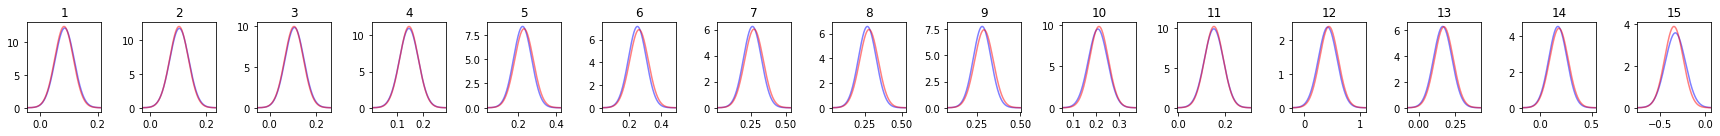

In [19]:
plot_bands_dist(NUM_BANDS,trn_stats_mean_df,trn_stats_std_df,tst_stats_mean_df,tst_stats_std_df)
print('Train (blue) vs. Test (red) Band value distribution comparision')

## Load Images and Masks


In [20]:
train_images = load_tif_files(s2_resized,'Train')
# dev_images = load_tif_files(s2_resized_dev,'Dev')
test_images = load_tif_files(s2_resized_test,'Test')

Train - 700 image files in /content/s2_resized/
Test - 60 image files in /content/s2_resized_test/


In [21]:
#check a sample of the expected image and matching mask both ways
sample_mask = get_matching_mask_path(train_images[0],esm_aligned)
assert sample_mask != None
sample_image = get_matching_img_path(sample_mask,s2_resized)
assert sample_image != None
sample_image,sample_mask

('/content/s2_resized/R_1_91.tif', '/content/esm_aligned/ESM_91.tif')

## MultiChannel Dataset and Scaler

In [22]:
stats_mean_df = pd.read_csv(STATS_METADATA_DIR + 'down_stats_mean_df.csv',header=0,index_col=0)
def get_global_chn_mean(band):
  '''
  Returns the global mean of a channel based on the statistics calculated in preprocessing
  Used for imputation of nan values in expoerted images (last resort...)
  '''
  return stats_mean_df[band].mean()

## Augmentations
Required for multi channel images (and their masks) using [Albumenations](https://albumentations.ai/docs/examples/example_kaggle_salt/#Using-Albumentations-for-a-semantic-segmentation-task)

In [23]:
#From https://albumentations.ai/docs/examples/example_kaggle_salt/#Using-Albumentations-for-a-semantic-segmentation-task
width=300
height=300
class SegmentationAlbumentationsTransform(ItemTransform):
  
    def __init__(self, aug): self.aug = aug
    def encodes(self, img,mask):
        # for albumentations to work correctly, the channels must be at the last dimension
        aug = self.aug(image=np.array(img.permute(1,2,0)), mask=np.array(mask))
        return TensorImage(aug['image'].transpose(2,0,1)), TensorMask(aug['mask'])

prob=0.2
#Half size is a popular choice of augmenation for segmentation tasks
aug_pipe = A.Compose([
                      A.RandomSizedCrop(min_max_height=(298, 298), height=height, width=width, p=prob),
                      A.PadIfNeeded(min_height=height, min_width=width, always_apply=True), 
                      # A.VerticalFlip(p=prob),
                      A.RandomRotate90(p=prob)])

# # Create our class with this aug_pipe
aug = SegmentationAlbumentationsTransform(aug_pipe)

augs_list = []
for a in aug_pipe:
  augs_list.append(a.__class__.__name__)
augs_list

['RandomSizedCrop', 'PadIfNeeded', 'RandomRotate90']

## Classes 

Originally we have 4 classes in the input images:
- 250 for non-residential **(Red)**
- 255 for residential     **(Blue)**
- 1 for all other areas   **(Green , merged into 0)**
- 0 for no data           **(Green also)**

We turn them to a sequence 0 to 3 for the segmentation to work properly:
codes decoder dictionary (0,1,2,3)->(0,1,250,255)

After many experiments we merged the 0 and 1 classes into 0 - which is the "background" class

In [24]:
CMAP='brg_r'

In [25]:
MERGE_BG_CLASSES=True
if(MERGE_BG_CLASSES):
  code2class = {0:0,1:250,2:255}
  class2code={0:0,250:1,255:2}
  class2desc={0:'Other',250:'Non Resi',255:'Resi'}
else:
  code2class = {0:0,1:1,2:250,3:255}
  class2code={0:0,1:1,250:2,255:3}
  class2desc={0:'No Data',1:'Other',250:'Non Resi',255:'Resi'}

In [26]:
%%time

# train_ds = S2ESMDataset(train_images,esm_aligned,code2class,aug=None) #Nם augmentations
train_ds = S2ESMDataset(train_images,esm_aligned,code2class,aug=aug) #add augmentations
# dev_ds   = S2ESMDataset(dev_images,esm_aligned_dev,code2class)
test_ds  = S2ESMDataset(test_images,esm_aligned_test,code2class)

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

CPU times: user 23.2 s, sys: 4.71 s, total: 27.9 s
Wall time: 31.2 s


In [27]:
img1_arr,msk1_arr = train_ds.get_one(1)
img1_arr[0],img1_arr[1].shape,msk1_arr[0],msk1_arr[1].shape

('/content/s2_resized/R_1_95.tif',
 torch.Size([15, 300, 300]),
 '/content/esm_aligned/ESM_95.tif',
 torch.Size([300, 300]))

Show 2 samples , normalized and RGB with and without augmentations

The augmented images may look the same as the original, depending on the augmentation probability (default 0.2) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 300, 300]) torch.Size([300, 300])


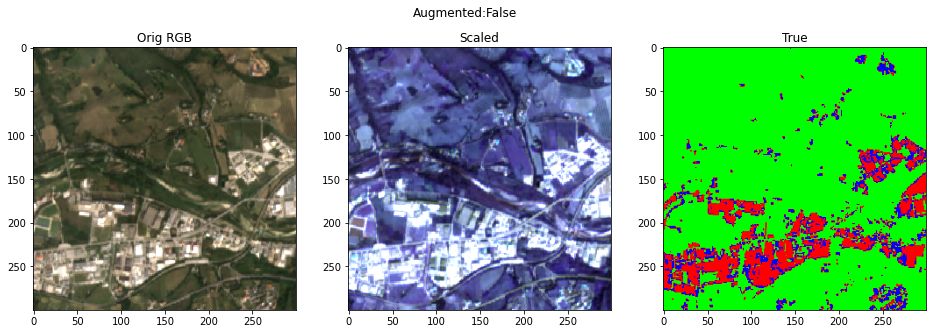

In [28]:
show_one(train_ds,2,train_images,cmap=CMAP)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 300, 300]) torch.Size([300, 300])


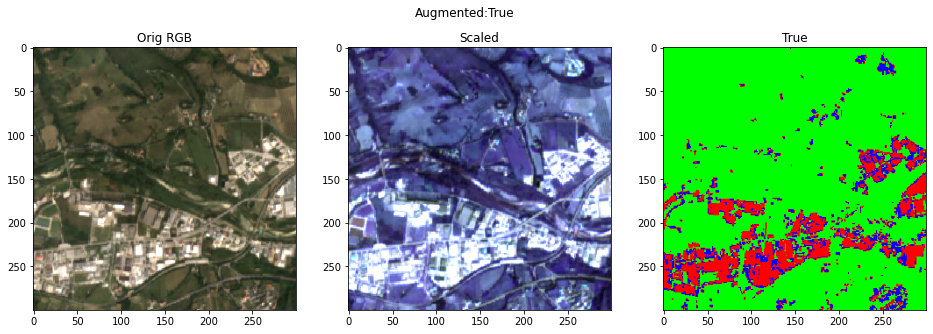

In [29]:
show_one(train_ds,2,train_images,cmap=CMAP,with_aug=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 300, 300]) torch.Size([300, 300])


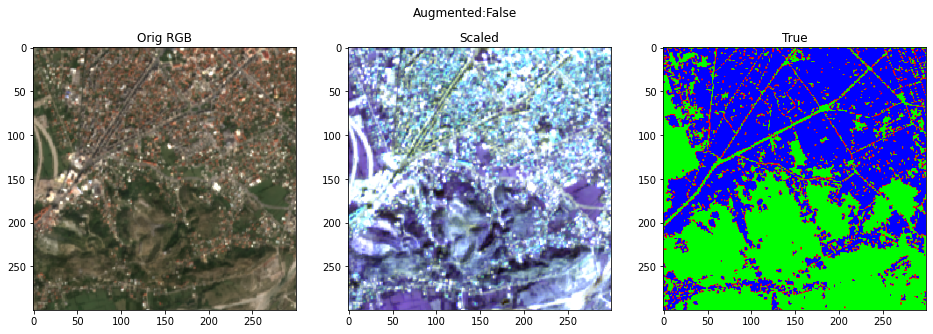

In [30]:
show_one(train_ds,12,train_images,cmap=CMAP)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([15, 300, 300]) torch.Size([300, 300])


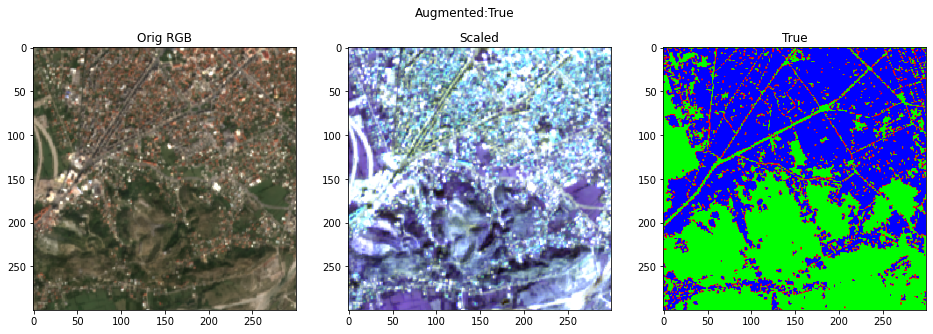

In [31]:
show_one(train_ds,12,train_images,cmap=CMAP,with_aug=True)

## Create Dataloaders (Batch size)

In [32]:
BS=4
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BS, shuffle=True)
# dev_dl = torch.utils.data.DataLoader(dev_ds, batch_size=NUM_DEV, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=BS, shuffle=False)
print('Train batches:',len(train_dl))
# print('Dev batches:',len(dev_dl))
print('Test batches:',len(test_dl))

Train batches: 175
Test batches: 15


## UNET Model

Our best model is using UNet architechture (for more details about UNet see: https://paperswithcode.com/paper/u-net-convolutional-networks-for-biomedical)


Based on the UNet implementation of [pytorch/benchmark](https://github.com/pytorch/benchmark) 

(benchmark/torchbenchmark/models/pytorch_unet/pytorch_unet/unet/)

We added dropout, and experimented with deeper and wider network architechtures, but the default implemnetation does quite a good job.

## TRAINING - Hyperparams

BEST RUN: 

After training 300 epochs with CrossEntropyLoss - finetuning with FocalLoss(gamma=4) for 170 additional epochs ans smaller LRs LR=1e-05 WD=1e-04 instead of (LE=1e-03,WD=1e-02)

In [33]:
n_epochs=75 #300 best
n_channels = NUM_BANDS

LR=1e-03
WD=1e-02
#Best
# LR=1e-05
# WD=1e-04

#Used to finetune a trained model (saved as "final_model.pth")
FINE_TUNE = False
pretrained=False #pretrained doesn't work for images with more than 3 channels (we have 15)
n_classes=len(class2code)


#Best:
model_unet = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=True)
# model_unet = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=True,base_size=128)#bilinear=True) #False , True is usually better !!!

#Best: this is the best so far with LR=5e-05 and WD=1e-04
optimizer = torch.optim.AdamW(model_unet.parameters(), lr=LR,weight_decay=WD)
# optimizer = torch.optim.AdamW(model_unet.parameters())
# optimizer = torch.optim.Adam(model_unet.parameters(), lr=LR)

#Best
loss_fn = nn.CrossEntropyLoss() #BEST
#After training 300 epochs with CrossEntropyLoss - finetuning with FocalLoss(gamma=4) for 170 additional epochs ans smaller LRs LR=1e-05 WD=1e-04 instead of (LE=1e-03,WD=1e-02)
# loss_fn = FocalLoss(gamma=4) #not bad to try loss_fn = FocalLoss(gamma=2.2)
# loss_fn = DiceLoss(reduction='mean',square_in_union=True) #not bad


In [34]:
%%time

clear_cache()

def load_pretrained():
    model_unet.load_state_dict(torch.load(FINAL_MODEL_PATH),strict=False)
    print('loaded model from:',FINAL_MODEL_PATH)
    return model_unet.to(device)
    
FINAL_MODEL_PATH=WORK_DIR+'models/final_model.pth'
final_states_dict_file = Path(FINAL_MODEL_PATH)
INFERECE_MODE=final_states_dict_file.is_file() and not FINE_TUNE
if(FORCE_TRAIN):
  INFERECE_MODE=False
print('Inference Mode:',INFERECE_MODE,', Fine tuning:',FINE_TUNE)

if(INFERECE_MODE):
  print('Inference mode: skipping training, loading model states dict...')
  model_unet = load_pretrained()
else:
  if(FINE_TUNE):
    model_unet = load_pretrained()
  loss_train_arr = [];loss_dev_arr = []; dice_train_arr =[]; dice_dev_arr=[]
  #run training
  loss_train_arr , loss_dev_arr , dice_train_arr , dice_dev_arr = \
    train_loop(model_unet,n_epochs,train_dl,test_dl,optimizer,loss_fn,
               device=device,verbose=True,early_stopping=5,n_classes=n_classes)
    #without Dev DS
    # train_loop(model_unet,n_epochs,train_dl,None,optimizer, \
    # loss_fn,device=device,verbose=True,early_stopping=10)

Inference Mode: True , Fine tuning: False
Inference mode: skipping training, loading model states dict...
loaded model from: urban_segmentation/models/final_model.pth
CPU times: user 1.53 s, sys: 902 ms, total: 2.44 s
Wall time: 7.55 s


In [35]:
if(not INFERECE_MODE):
  print(np.mean(dice_train_arr))

In [36]:
if(not INFERECE_MODE):
  loss_graph(loss_train_arr , loss_dev_arr , dice_train_arr , dice_dev_arr)

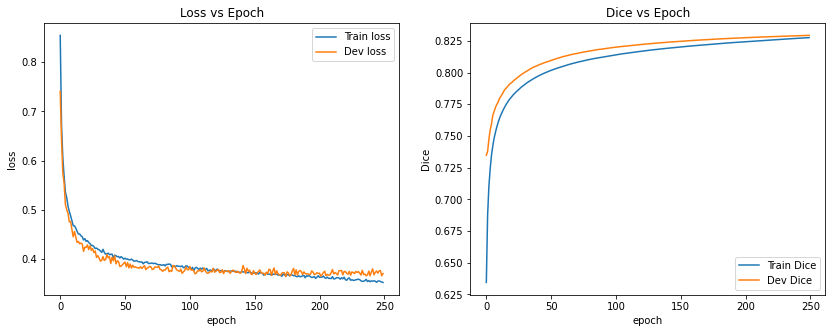

## Save Weights

In [37]:
if((not INFERECE_MODE) or (FINE_TUNE)):
  print('Saving new best model...')
  !mkdir -p {NB_DIR}'/models/'
  MODEL_WGTS_FILE = NB_DIR+'/models/model.pth'
  torch.save(model_unet.state_dict(), MODEL_WGTS_FILE)
  !ls {MODEL_WGTS_FILE}
  !cp {NB_DIR}/models/model.pth {TRAINED_MODEL_REMOTE_PATH}/final_model.pth

## Evaluate

UNET Model Evaluation (Sample of Train) 



  0%|          | 0/175 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       Other      0.925     0.908     0.916   5497441
    Non Resi      0.801     0.812     0.806    340552
        Resi      0.753     0.788     0.770   2082007

    accuracy                          0.872   7920000
   macro avg      0.826     0.836     0.831   7920000
weighted avg      0.874     0.872     0.873   7920000

**************UNET Model Evaluation (Sample of Train) Mean Dice score:0.871**************
CPU times: user 37.2 s, sys: 1.77 s, total: 38.9 s
Wall time: 44.7 s


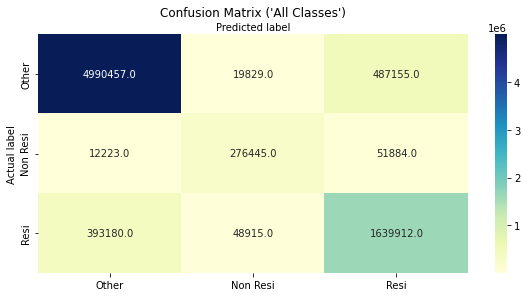

In [38]:
%%time
clear_cache()
f1_all,train_preds,train_dice  = \
    evaluate(model=model_unet, dl=train_dl, caption = "UNET Model Evaluation (Sample of Train)" , \
             plot_cm = True , print_scores = True,device=device,
             class2desc=class2desc,code2class=code2class,max_batches=20)

## Save training results

In [39]:
start = datetime.now()
# dd/mm/YY H:M:S
dt_string = start.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

model_name = 'unet'
arch_name = 'resnet50'
if(not INFERECE_MODE):
  trn_loss = np.mean(loss_train_arr) if loss_train_arr!=None else 0
  val_loss = np.mean(loss_dev_arr) if loss_dev_arr!=None else 0
  dice_score = np.mean(dice_dev_arr)
fg_acc = np.nan

date and time = 01/08/2022 15:46:24


In [40]:
train_dice,f1_all

(0.8712351, 0.8730013074491415)

In [41]:
if(INFERECE_MODE):
  pass
else:
  !mkdir -p logs
  cols=['datetime','model','num_epochs','loss_fn','batch_size',
      'arch','optim','channels','pretrained','lr','valid_pct',
      'trn_loss','val_loss','dice','f1','augs','epoch_time']
  
  results=pd.DataFrame(columns=cols)
  new_expriment_log=[dt_string,model_name,n_epochs,loss_fn.__class__.__name__,BS,
      arch_name,optimizer.__class__.__name__,n_channels,pretrained,LR,NUM_TST,
      np.mean(loss_train_arr),val_loss,train_dice,f1_all,augs_list,datetime.now()-start]
  print(len(cols),len(new_expriment_log))
  results.loc[len(results)] = new_expriment_log
  display(results)
  results.to_csv('logs/exp_results_log.csv', mode='a', index=False, header=False)

## Compare class proprtions , similiarity of original and generated masks

First "predict" a mask for all the **training** data

In [42]:
clear_cache()
#clean old predicted "train" files
# PREDS_DIR= 'preds'
PREDS_DIR= '/content/preds'
!mkdir -p {PREDS_DIR} && ls {PREDS_DIR} | wc -l && rm -f {PREDS_DIR}/*.tif

0


In [43]:
BU_PROP='BU_prop'
c250_IN_BU = 'p250_in_bu'
c255_IN_BU ='p255_in_bu'

The following dataframe has 3 types of rows: 
- ORIG - original mask statistics
- PRED - predicted mask statistics
- DIFF - the difference between the Original and the Mask

Every 3 sequential rows represent a single "tuple" of (image,orig mask, pred mask)

Scores dataframe holds trios of image,mask,predicted mask, with their scores: Foreground Accuracy, Dice

In [44]:
BEST_THRESH=0.015
WORST_THRESH=0.015

## INFERENCE on unseen images (TEST)

In [45]:
dev_scores_df = pd.DataFrame(columns=['image_name','mask_name','pred_name','FG_Acc', 'Dice'])

UNET Model (Test) 



  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       Other      0.940     0.924     0.932   3165998
    Non Resi      0.794     0.815     0.805    160961
        Resi      0.755     0.791     0.773    993041

    accuracy                          0.890   4320000
   macro avg      0.830     0.844     0.837   4320000
weighted avg      0.892     0.890     0.891   4320000

**************UNET Model (Test) Mean Dice score:0.889**************


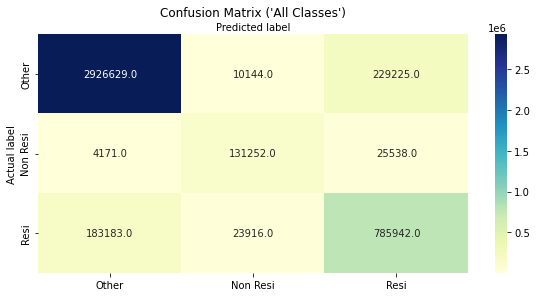

In [46]:
clear_cache()
_,test_preds,test_dice  = evaluate(model=model_unet, dl=test_dl, caption = "UNET Model (Test)" , \
                                   plot_cm = True , print_scores = True, device=device, \
                                   class2desc=class2desc,code2class=code2class)

In [47]:
flat_preds = [x for xs in test_preds for x in xs]
print(len(test_images),len(flat_preds))

60 48


In [48]:
pred_test_prop_df = build_proportions_df(test_images,flat_preds,esm_aligned_test,code2class)
pred_test_prop_df.head()

0it [00:00, ?it/s]

type   image_name    mask_name        0        1  250    255   BU_prop  \
0  ORIG   R_1_95.tif   ESM_95.tif      371    69931   20  19678  0.218867   
1  PRED   R_1_95.tif   ESM_95.tif    71051      0.0   20  18929  0.210544   
2  DIFF   R_1_95.tif   ESM_95.tif  70680.0  69931.0  0.0  749.0  0.008322   
3  ORIG  R_4_359.tif  ESM_359.tif      282    74232   22  15464  0.172067   
4  PRED  R_4_359.tif  ESM_359.tif    74135      0.0    7  15858  0.176278   

   p250_in_bu  p255_in_bu  
0    0.001015    0.998985  
1    0.001055    0.998945  
2    0.000040    0.000040  
3    0.001421    0.998579  
4    0.000441    0.999559

In [49]:
test_orig_only_df = pred_test_prop_df.where(pred_test_prop_df['type']=='ORIG').dropna()
test_pred_only_df = pred_test_prop_df.where(pred_test_prop_df['type']=='PRED').dropna()
test_diff_only_df = pred_test_prop_df.where(pred_test_prop_df['type']=='DIFF').dropna()
# display(test_diff_only_df.describe())
sum(test_diff_only_df.BU_prop > WORST_THRESH),display(test_diff_only_df.head())

type   image_name    mask_name        0        1    250     255   BU_prop  \
2   DIFF   R_1_95.tif   ESM_95.tif  70680.0  69931.0    0.0   749.0  0.008322   
5   DIFF  R_4_359.tif  ESM_359.tif  73853.0  74232.0   15.0   394.0  0.004211   
8   DIFF  R_6_524.tif  ESM_524.tif  69478.0  70632.0  874.0   280.0  0.012822   
11  DIFF  R_2_134.tif  ESM_134.tif  70648.0  70635.0  225.0   238.0  0.000144   
14  DIFF  R_6_589.tif  ESM_589.tif  65872.0  69051.0  146.0  3325.0  0.035322   

    p250_in_bu  p255_in_bu  
2     0.000040    0.000040  
5     0.000979    0.000979  
8     0.038153    0.038153  
11    0.012338    0.012338  
14    0.013698    0.013698

(22, None)

In [50]:
test_om=test_orig_only_df[BU_PROP]
test_nm=test_pred_only_df[BU_PROP]
# len(test_om),len(test_nm)

  0%|          | 0/48 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


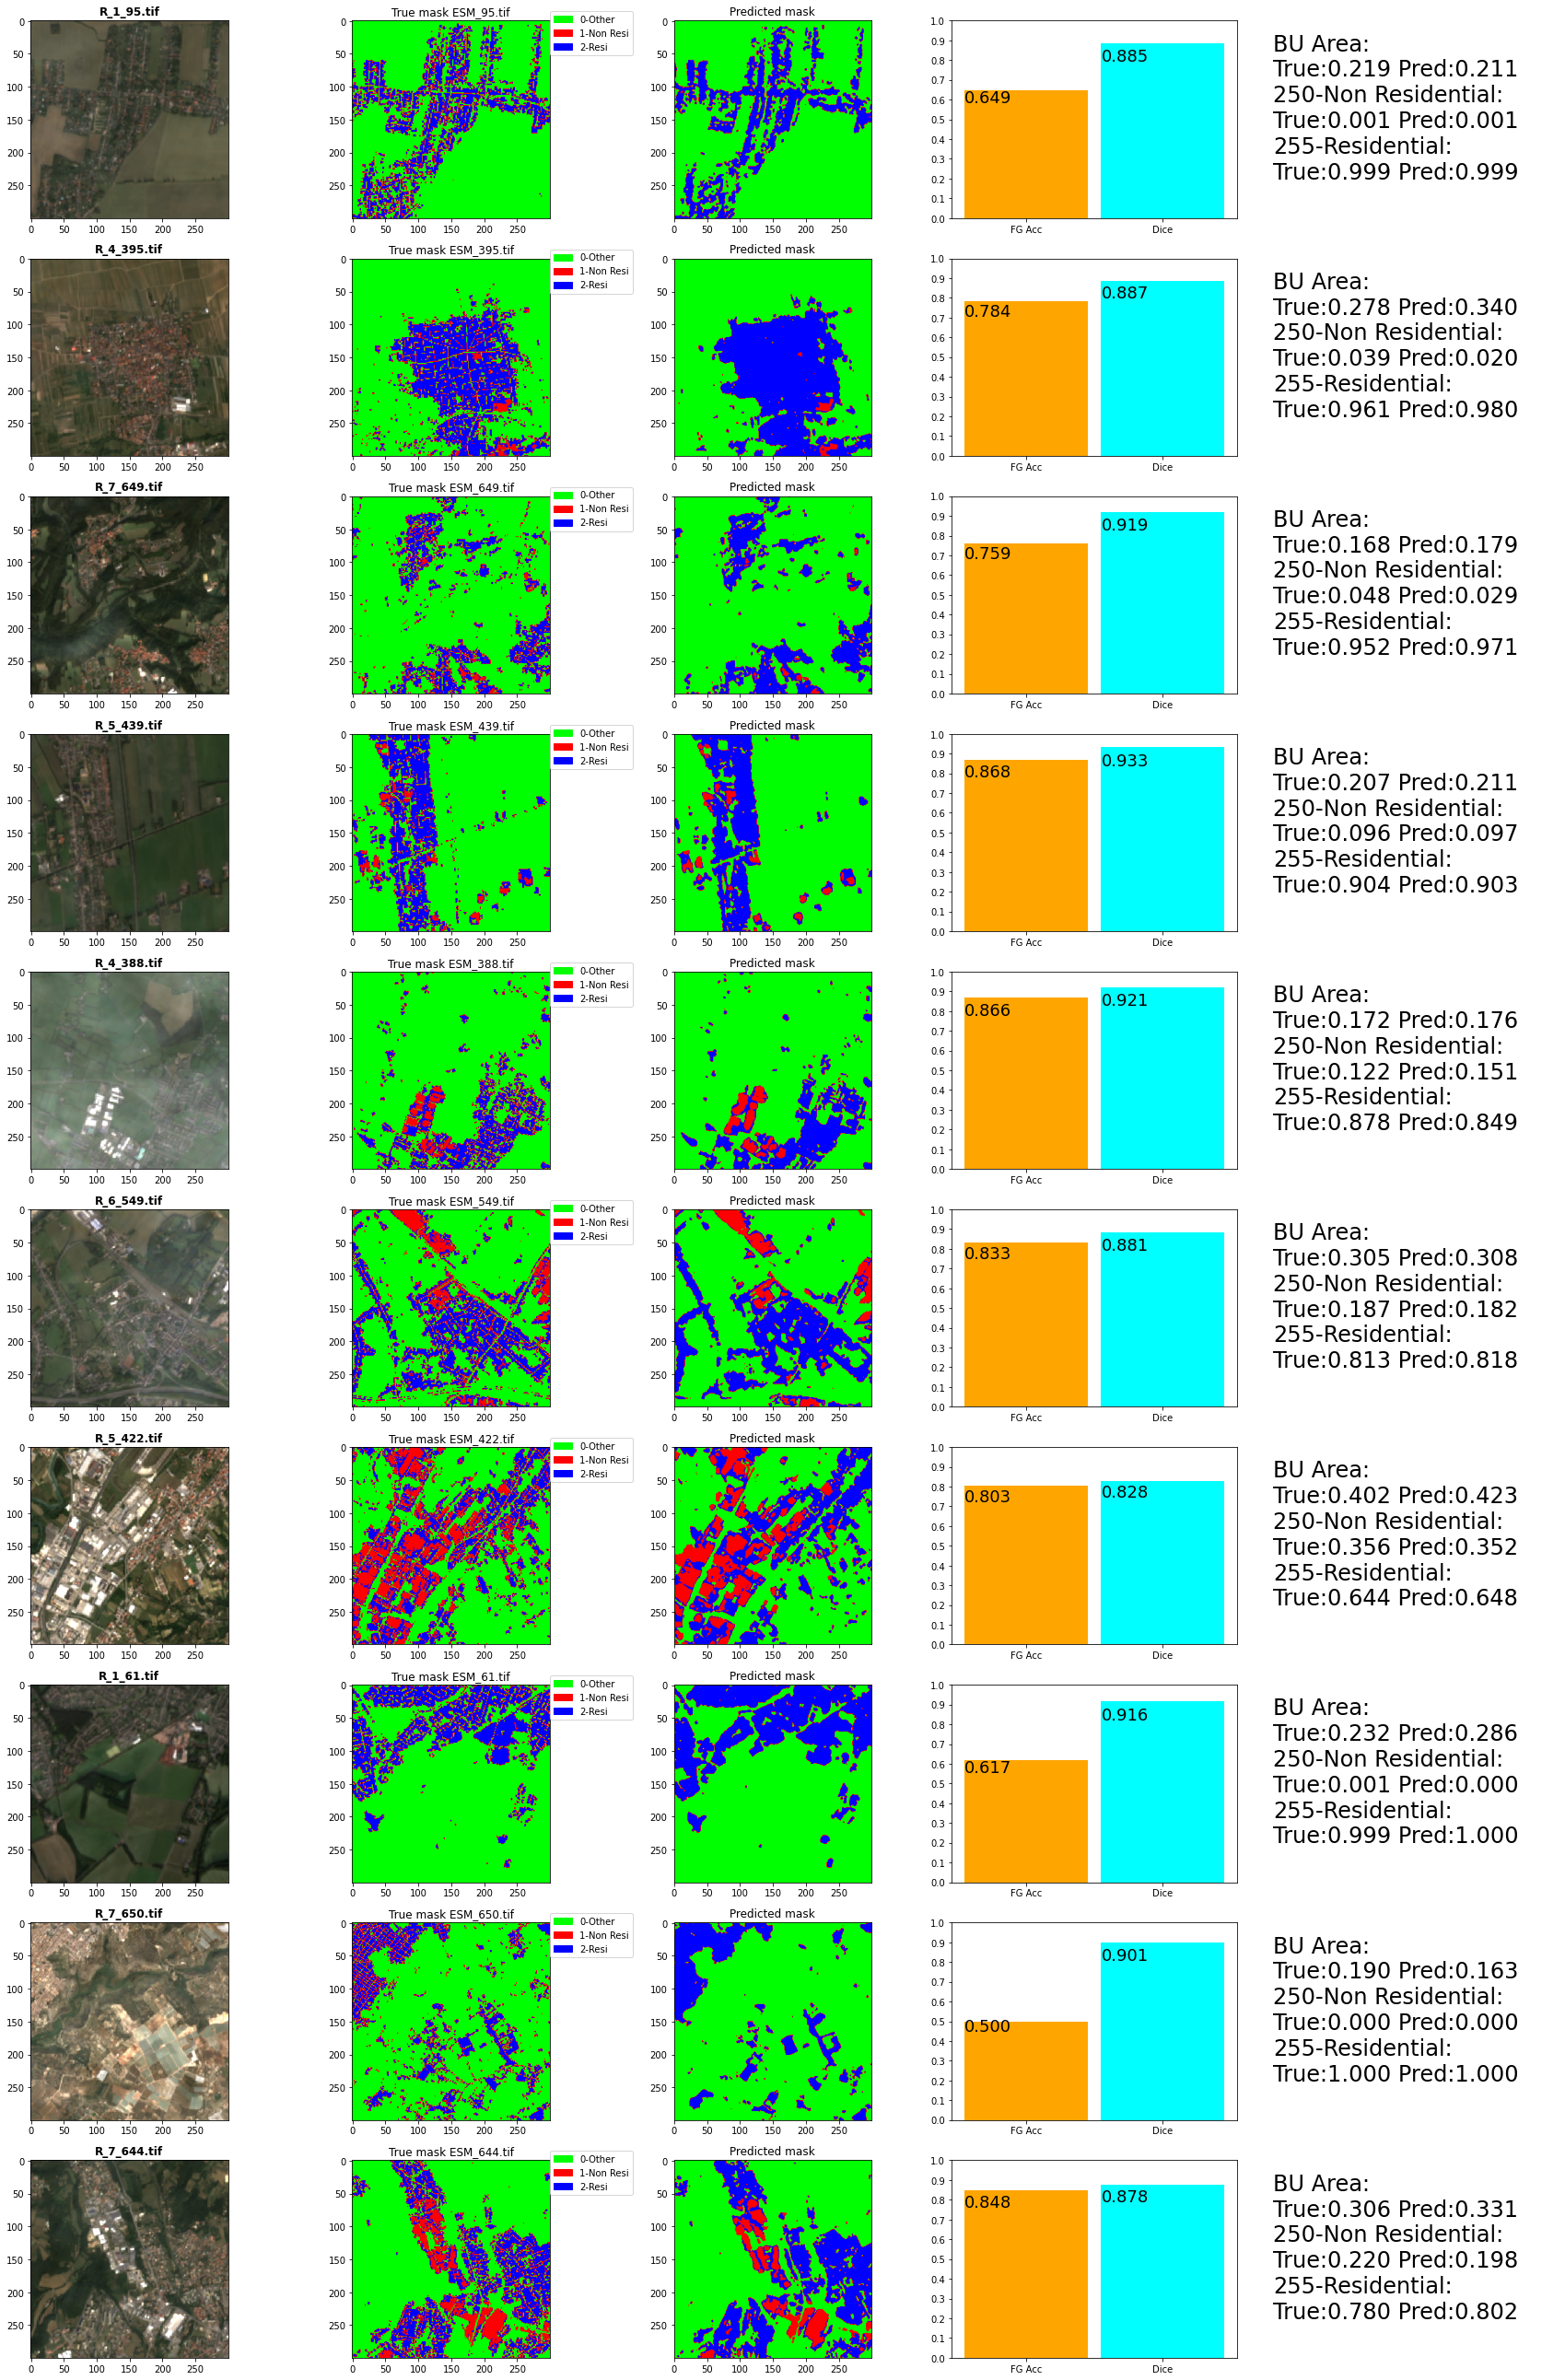

In [51]:
test_scores_df = pd.DataFrame(columns=dev_scores_df.columns)
test_scores_df = plot_final_results(test_images,flat_preds,pred_test_prop_df,
                                    s2_resized_test,esm_aligned_test,
                                    scores_df=test_scores_df,cmap=CMAP,
                                    code2class=code2class,class2code=class2code,
                                    class2desc=class2desc,preds_dir=PREDS_DIR,show_every=5)

In [52]:
TEST_WORST_THRESH=.1
test_quite_good = abs(test_nm.values.reshape(len(test_nm))-test_om.values.reshape(len(test_om)))<BEST_THRESH
test_worst= (abs(test_nm.values.reshape(len(test_nm))-test_om.values.reshape(len(test_om)))>TEST_WORST_THRESH)
sum(test_quite_good),sum(test_worst)

(26, 0)

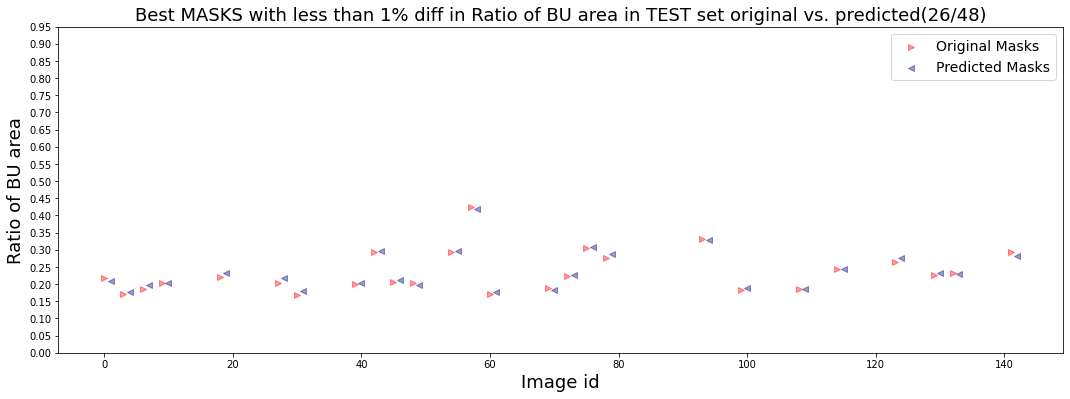

In [53]:
plot_scatter_diff(test_om,test_nm,'Best MASKS with less than {}% diff in Ratio of BU area in TEST set original vs. predicted({}/{})',test_quite_good,BEST_THRESH)

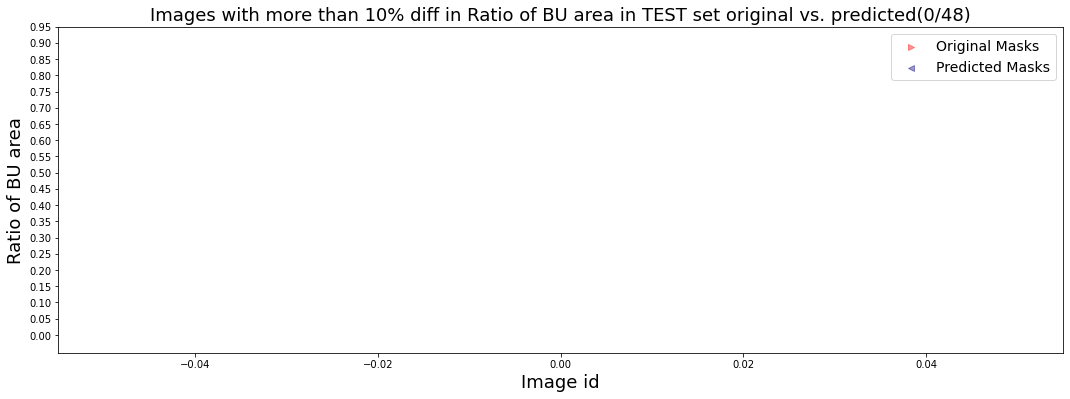

In [54]:
if(len(test_worst)>1):
  plot_scatter_diff(test_om,test_nm,'Images with more than {}% diff in Ratio of BU area in TEST set original vs. predicted({}/{})',test_worst,TEST_WORST_THRESH)

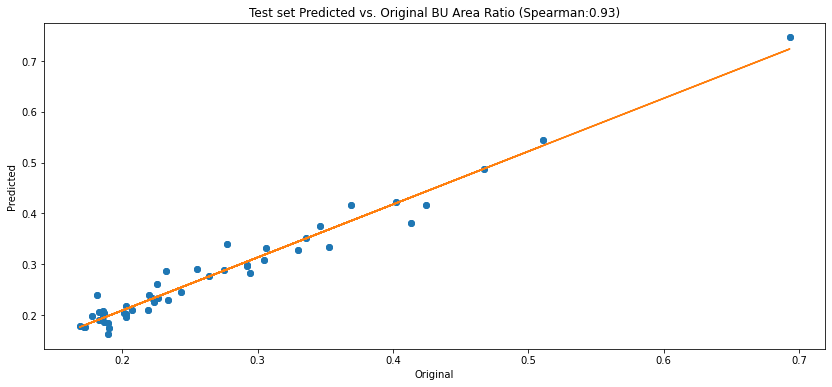

In [55]:
show_diag_plot(test_om,test_nm,title='Test')

In [56]:
print('Predicted masks with a BU proportion (BU_prop) difference of more than {}%'.format(TEST_WORST_THRESH*100))
test_worst_df = test_diff_only_df[test_worst]
test_worst_df

Predicted masks with a BU proportion (BU_prop) difference of more than 10.0%


Empty DataFrame
Columns: [type, image_name, mask_name, 0, 1, 250, 255, BU_prop, p250_in_bu, p255_in_bu]
Index: []

"Worst" Test Predictions

In [57]:
if(len(test_worst_df)>1):
  limited_list = list(test_worst_df['image_name'].values)
  plot_final_results(test_images,flat_preds,pred_test_prop_df,
                                      s2_resized_test,esm_aligned_test,
                                      scores_df=test_scores_df,cmap=CMAP,
                                      code2class=code2class,class2code=class2code,
                                      class2desc=class2desc,preds_dir=PREDS_DIR,
                                      show_every=1,show_only=limited_list)

In [58]:
def as_int(df):
  df[0] = df[0].astype(int)
  df[1] = df[1].astype(int)
  df[250] = df[250].astype(int)
  df[255] = df[255].astype(int)
  return df

orig_only_df=as_int(test_orig_only_df)
pred_only_df=as_int(test_pred_only_df)
diff_only_df=as_int(test_diff_only_df)


## Calculate confidence intervals for the test data results

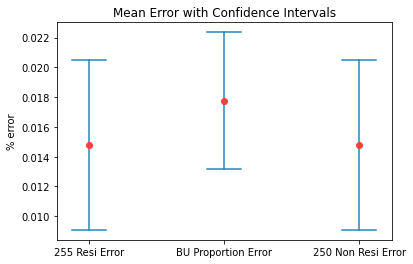

In [59]:
plt.xticks([1, 2, 3, 4], ['255 Resi Error', 'BU Proportion Error', '250 Non Resi Error'])
plt.title('Mean Error with Confidence Intervals')
plot_confidence_interval(1, diff_only_df[c255_IN_BU])
plot_confidence_interval(2, diff_only_df[BU_PROP])
plot_confidence_interval(3, diff_only_df[c250_IN_BU])
# plot_confidence_interval(4, [30, 31, 42, 45, 44])
plt.show()

Class 0 and 1 were merged into 0 - which explains the difference in the distributions on the left plot below

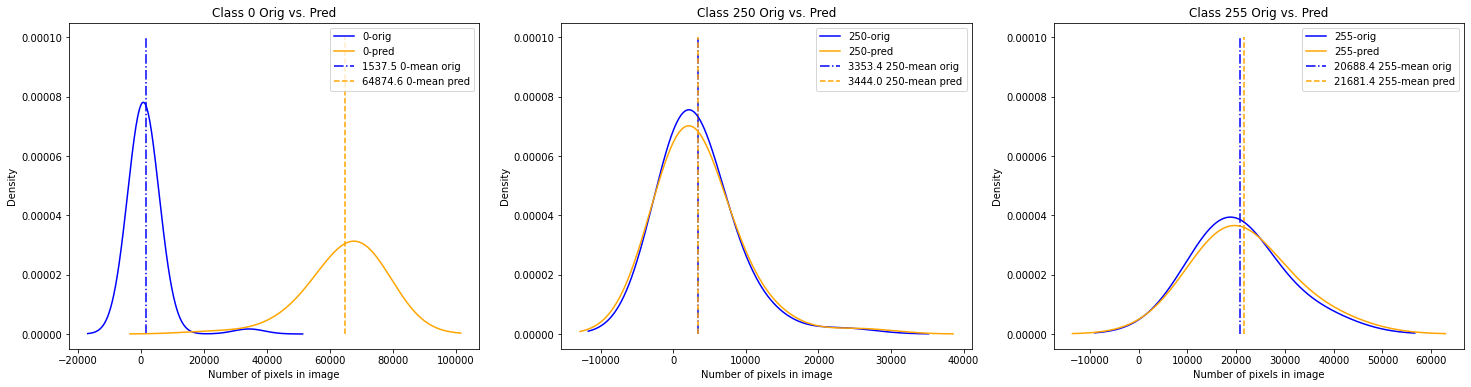

In [60]:
f,axs = plt.subplots(1,len(class2desc),figsize=(25,6))
for i,c in enumerate(class2code):
  orig_only_df[c].plot.density(ax=axs[i],title='Class {} Orig vs. Pred'.format(c),color='b',bw_method=1,label='{}-orig'.format(c))
  axs[i].vlines(orig_only_df[c].mean(),0,0.0001,linestyle='-.',label='{:.1f} {}-mean orig'.format(orig_only_df[c].mean(),c),color='b')
  pred_only_df[c].plot.density(ax=axs[i],color='orange',bw_method=1,label='{}-pred'.format(c))
  axs[i].vlines(pred_only_df[c].mean(),0,0.0001,linestyle='--',label='{:.1f} {}-mean pred'.format(pred_only_df[c].mean(),c),color='orange')
  axs[i].set_xlabel('Number of pixels in image')
  axs[i].legend()


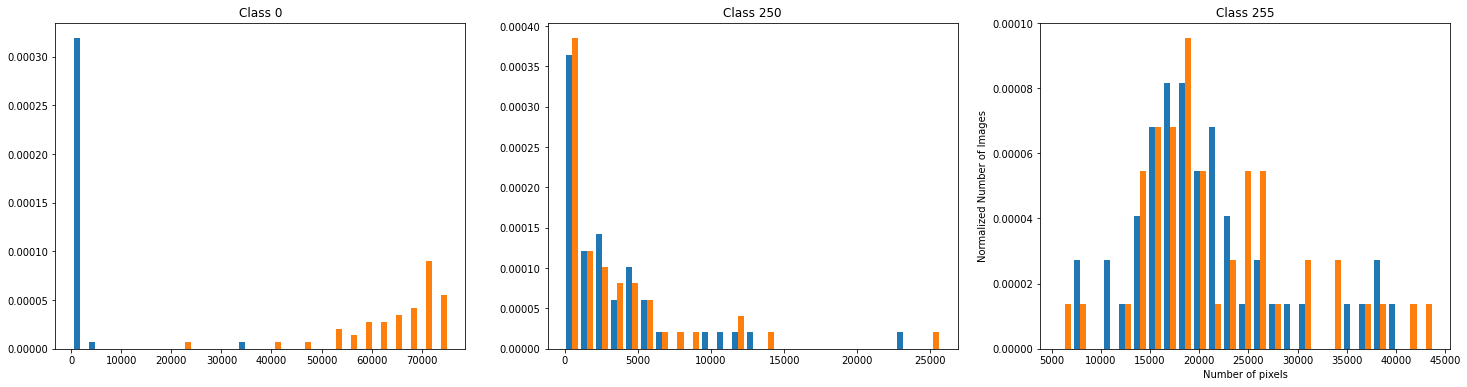

In [61]:
x0 = list(orig_only_df[0])
x1 = list(orig_only_df[1])
x250 = list(orig_only_df[250])
x255 = list(orig_only_df[255])
px0 = list(pred_only_df[0])
px1 = list(pred_only_df[1])
px250 = list(pred_only_df[250])
px255 = list(pred_only_df[255])

# Assign colors for each airline and the names
colors = ['blue', 'red', 'green', 'orange', 'cyan','purple','black','pink']
names = ['orig_0','orig_1','orig_250','orig_255','pred_0','pred_1','pred_250','pred_255']


f,axs = plt.subplots(1,len(class2code),figsize=(25,6))
for i,c in enumerate(class2code):      
  axs[i].hist([orig_only_df[c], pred_only_df[c]], bins = 25,    label=names,density=True)

  # plt.legend()
  plt.xlabel('Number of pixels')
  plt.ylabel('Normalized Number of Images')
  axs[i].set_title('Class {}'.format(c))


In [62]:
calc_conf_intervals(diff_only_df[BU_PROP],title='Mean BU Area proportion error confidence intervals:')


Mean BU Area proportion error confidence intervals:
mean=0.018, lower=-0.020, upper=0.055


In [63]:
calc_conf_intervals(diff_only_df[c250_IN_BU],title='Mean Non Residential BU Area proportion error - Confidence Intervals:')

Mean Non Residential BU Area proportion error - Confidence Intervals:
mean=0.015, lower=-0.019, upper=0.049


In [64]:
calc_conf_intervals(diff_only_df[c255_IN_BU],title='Mean Residential BU Area proportion error - Confidence Intervals:')

Mean Residential BU Area proportion error - Confidence Intervals:
mean=0.015, lower=-0.019, upper=0.049


In [65]:
!ls {PREDS_DIR} | wc -l

48


## Final Average Dice Scores

In [66]:
print('Train - Mean Dice score:{:.2f}'.format( train_dice)) 
# print('Dev - Mean Dice score:{:.2f}'.format( dev_dice)) 
print('Test - Mean Dice score:{:.2f}'.format( test_dice))

Train - Mean Dice score:0.87
Test - Mean Dice score:0.89


In [67]:
if(not INFERECE_MODE):
  print(np.mean(dice_train_arr))

# INFERENCE on downloaded images


In [68]:
preprocessed_test2_dir=ADDITIONAL_TEST_DIR
test2_images = load_tif_files(preprocessed_test2_dir,'Test Downloaded')
TARGET_PREDS_DIR = '/content/target_preds'
!rm -rf {TARGET_PREDS_DIR}
!mkdir -p {TARGET_PREDS_DIR}

Test Downloaded - 49 image files in /content/drive/MyDrive/gee_export_Jul_14_2022_1601test_prepproc/


In [69]:
%%time

test2_ds  = S2OnlyDataset(test2_images)
test2_dl = torch.utils.data.DataLoader(test2_ds, batch_size=1, shuffle=False)
print(len(test2_dl),'batches,',len(test2_ds),'images')

  0%|          | 0/49 [00:00<?, ?it/s]

49 batches, 49 images
CPU times: user 2.21 s, sys: 250 ms, total: 2.46 s
Wall time: 3.84 s


In [70]:
clear_cache()

test2_preds = predict(model_unet,test2_dl,device)

  0%|          | 0/49 [00:00<?, ?it/s]

49 49


  0%|          | 0/49 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred masks saved to: /content/target_preds


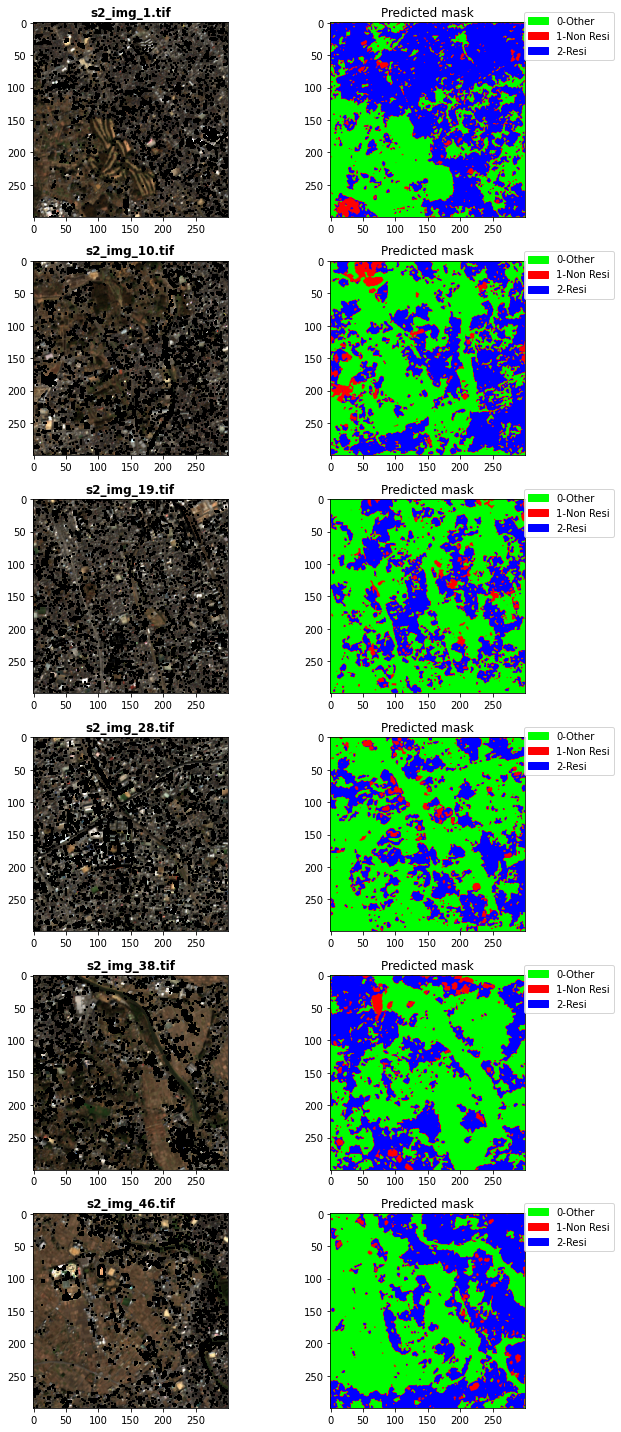

In [71]:
flat2_preds = [x for xs in test2_preds for x in xs]
print(len(test2_images),len(flat2_preds))
plot_predictions(test2_images,flat2_preds,preprocessed_test2_dir,
                 TARGET_PREDS_DIR,cmap=CMAP,code2class=code2class,
                 class2desc=class2desc,show_every=9)

In [72]:
if(BACKUP):
  !cp -rf {TARGET_PREDS_DIR} {REMOTE_TARGET_PREDS_DIR}
  !cp -rf {PREDS_DIR} {REMOTE_TARGET_PREDS_DIR}

49


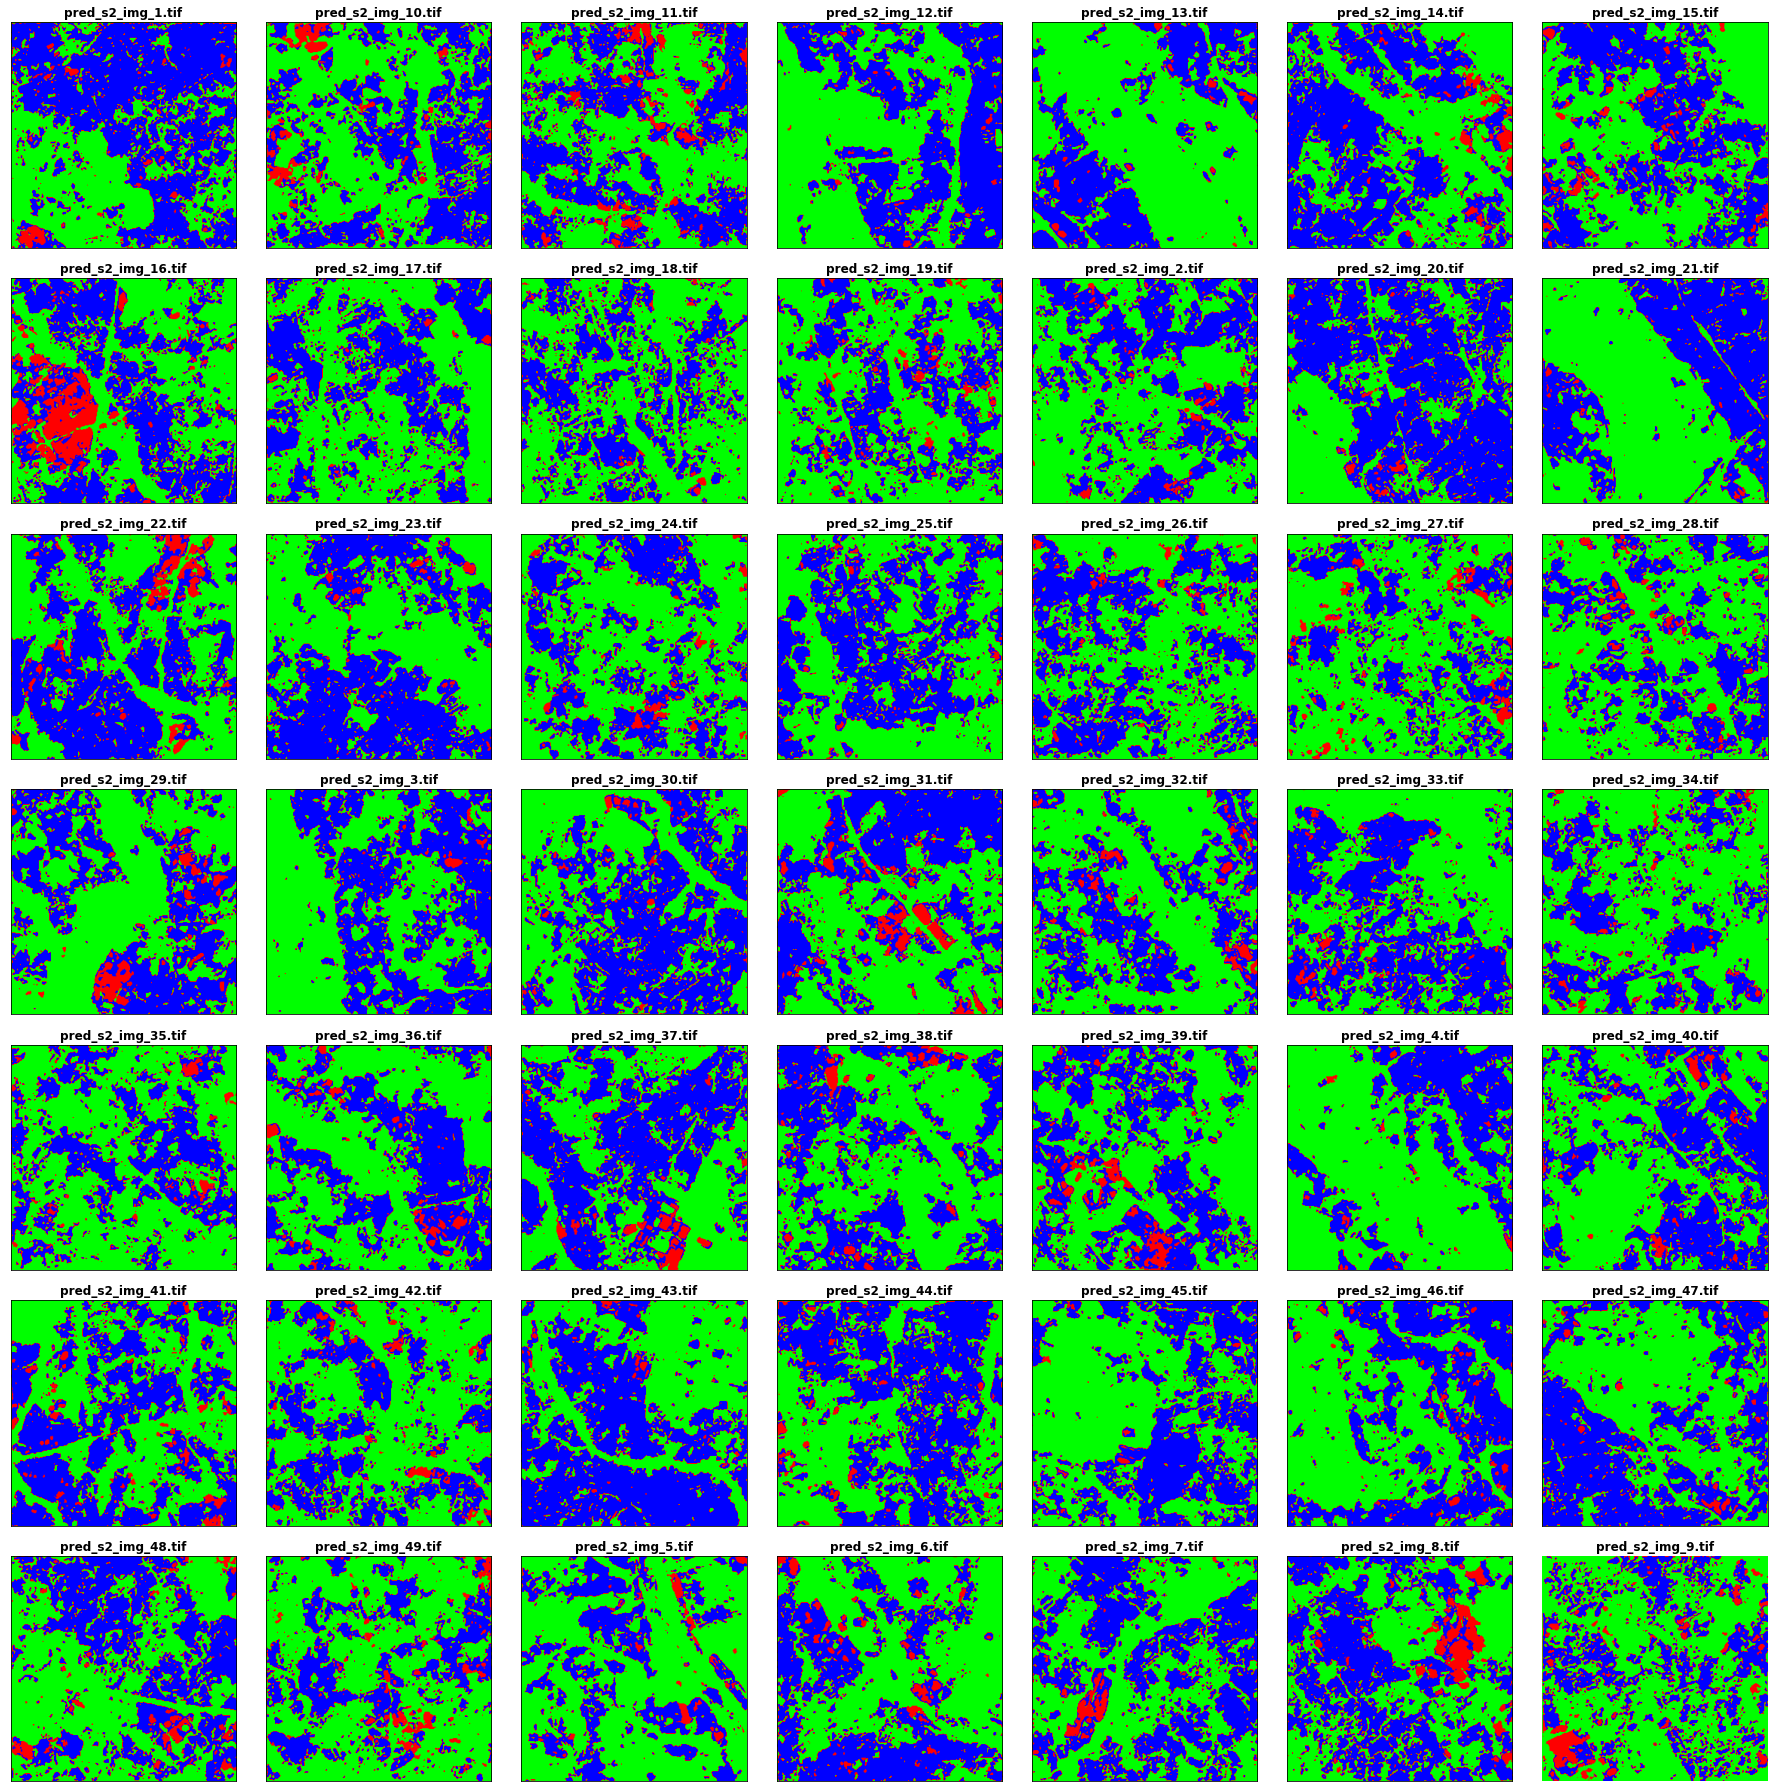

In [73]:
SAITAMA = TARGET_PREDS_DIR
sait = glob.glob(os.path.join(SAITAMA,'*.tif'))
sait = sorted(sait)
print(len(sait))
f,axs = plt.subplots(7,7,figsize=(25,25))
im_no = 0
for i in range(7):
  for j in range(7):
    a = show_image(sait[im_no],bands=[1],cm=CMAP,title='{}'.format(parse_file_name(sait[im_no])),ax=axs[i,j])
    axs[i,j].axes.xaxis.set_visible(False)
    axs[i,j].axes.yaxis.set_visible(False)
    im_no+=1
plt.axis("off")
plt.tight_layout()
plt.show()

## Zoom in on some images that had "red edges" in Jul 18th

10


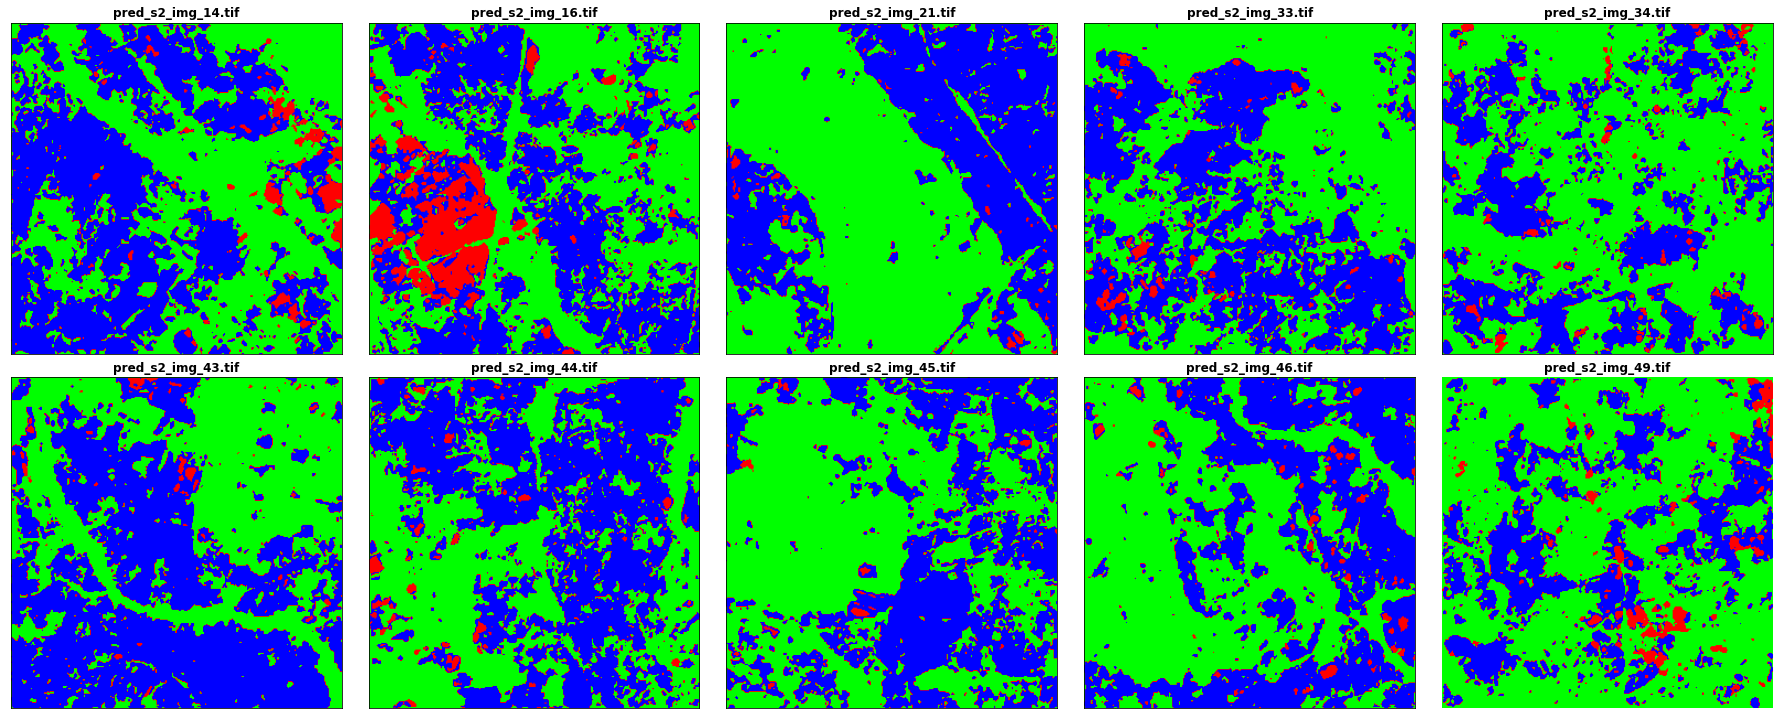

In [74]:
img_2_plot = ['_21.tif','_33.tif','_34.tif','_43.tif','_44.tif','_45.tif','_46.tif','_49.tif','_14.tif','_16.tif']
sait2 = sorted(sait)
sait2 = [img for img in sait2 if img[-7:] in img_2_plot]
print(len(sait2))
f,axs = plt.subplots(2,5,figsize=(25,10))
im_no = 0
for i in range(2):
  for j in range(5):
    a = show_image(sait2[im_no],bands=[1],cm=CMAP,title='{}'.format(parse_file_name(sait2[im_no])),ax=axs[i,j])
    axs[i,j].axes.xaxis.set_visible(False)
    axs[i,j].axes.yaxis.set_visible(False)
    im_no+=1
plt.axis("off")
plt.tight_layout()
plt.show()

References:

Some code snippets and inspiration:

https://gist.github.com/jaeeolma/0846e03c0c3b613212f8ca5824ae47e0

https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Binary_Segmentation.ipynb

[Semantic Segmentation for Edge Detection](file:///C:/Users/liadl/Desktop/remotesensing-14-00613-v2.pdf)

Focal Loss paper : https://arxiv.org/pdf/1708.02002.pdf

Paper with metric results on S2: https://www.mdpi.com/2072-4292/13/12/2292/htm

Combined Focal and Dice loss: https://arxiv.org/abs/2102.04525

Feature selection of Sentinel2 imagery:
https://www.mdpi.com/2072-4292/11/16/1892/htm

Loss functions:
https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook
